In [1]:
from __future__ import unicode_literals
import nltk
import numpy as np
from hazm import *
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Import matplotlib and create a helper function to plot graphs:

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [3]:
#import data

dataset = pd.read_csv("digikala_comment_verification_challenge/train_comments.csv", na_values=" ")
dataset = dataset.dropna()
X = dataset.iloc[:, 1: 4].values
y = dataset.iloc[:, 4].values

In [4]:
# preprocess data
normalizer = Normalizer()
stemmer = Stemmer()
vocabulary_set = set()

X_new = []
for i in range(len(X)):
    words = []
    for j in range(2):
        X[i][j] = normalizer.normalize(X[i][j])
        temp = word_tokenize(X[i][j])
        for k in range(len(temp)):
            token = stemmer.stem(temp[k])
            words.append(token)
    X_new.append(words)
    vocabulary_set.update(words)

X = np.array(X_new)
y = np.array(y)

In [5]:
for i in range(len(X)):
    X[i] = ' '.join(X[i])

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [24]:
vocab_size = len(vocabulary_set)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [25]:
# Create an encoder

encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)


In [26]:
def encode(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label

def encode_map_fn(text, label):
    # py_func doesn't set the shape of the returned tensors.
    encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))

    # `tf.data.Datasets` work best if all components have a shape set
    #  so set the shapes manually: 
    encoded_text.set_shape([None])
    label.set_shape([])

    return encoded_text, label


train_dataset = train_dataset.map(encode_map_fn)
test_dataset = test_dataset.map(encode_map_fn)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4


In [27]:
for x in train_dataset:
    print(x)
    break

(<tf.Tensor: shape=(59,), dtype=int64, numpy=
array([ 1231, 48747, 29250, 44624, 31950, 88865, 90618, 25900, 17113,
       72180, 82612, 44929, 25380, 85809, 63218, 56078, 83028, 14671,
       63218, 47131, 92885, 10888, 40716, 85809,   582,  1348, 65307,
       13363,  4599, 55984, 50065, 43476,  9551, 78418, 62355, 73491,
       91877, 72180, 54375, 10982, 24544, 62883, 10257, 16276, 78672,
       68273,  1231, 25380, 53466, 55617, 37166,  2838, 15074, 83028,
       66206, 11883,  3885, 73491, 31950])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [28]:
#prepare data
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)

train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes = ([None],()))

test_dataset = test_dataset.padded_batch(BATCH_SIZE, padded_shapes = ([None],()))


In [29]:
#create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [30]:
#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [31]:
#train the model
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Train for 2189 steps, validate for 30 steps
Epoch 1/10
2189/2189 [==============================] - 1240s 566ms/step - loss: 0.3453 - accuracy: 0.8655 - val_loss: 0.2675 - val_accuracy: 0.8953
Epoch 2/10
2189/2189 [==============================] - 1231s 562ms/step - loss: 0.2681 - accuracy: 0.8979 - val_loss: 0.2587 - val_accuracy: 0.9005
Epoch 3/10
2189/2189 [==============================] - 1231s 562ms/step - loss: 0.2453 - accuracy: 0.9080 - val_loss: 0.2611 - val_accuracy: 0.9021
Epoch 4/10
2189/2189 [==============================] - 1196s 546ms/step - loss: 0.2285 - accuracy: 0.9152 - val_loss: 0.2680 - val_accuracy: 0.9010
Epoch 5/10
2189/2189 [==============================] - 1217s 556ms/step - loss: 0.2141 - accuracy: 0.9214 - val_loss: 0.2776 - val_accuracy: 0.9026
Epoch 6/10
2189/2189 [==============================] - 1229s 561ms/step - loss: 0.2006 - accuracy: 0.9267 - val_loss: 0.2852 - val_accuracy: 0.8995
Epoch 7/10
2189/2189 [==============================] - 1232s 

In [32]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

548/548 [==============================] - 272s 496ms/step - loss: 0.3637 - accuracy: 0.8844
Test Loss: 0.36374259206473175
Test Accuracy: 0.8843671679496765


In [33]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

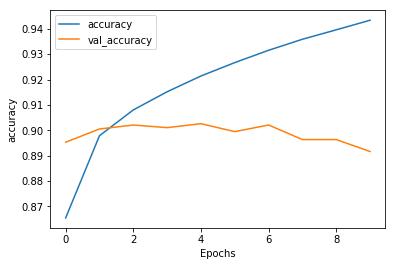

In [35]:
plot_graphs(history, 'accuracy')

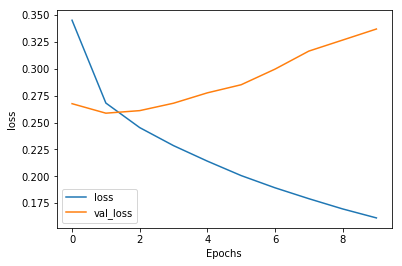

In [36]:
plot_graphs(history, 'loss')

In [37]:
#save model
model.save_weights("./checkpoints/my_checkpoint")